# Investment Value Prediction

## Library Definitions

In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import time
import tensorflow as tf
tf.config.optimizer.set_jit(False)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.regularizers import l2
import warnings

warnings.filterwarnings("ignore")

## Data Preparation

In [2]:
# Load the dataset using pandas and inspect the data
data = pd.read_csv('Foreign direct investment - FAOSTAT_data_en_2-27-2024.csv')
print("Dataset shape:", data.shape)
print("Dataset columns:", data.columns)
print("Dataset info:")
print(data.info())
print("Dataset head:")
print(data.head())

Dataset shape: (12276, 15)
Dataset columns: Index(['Domain Code', 'Domain', 'Area Code (M49)', 'Area', 'Element Code',
       'Element', 'Item Code', 'Item', 'Year Code', 'Year', 'Unit', 'Value',
       'Flag', 'Flag Description', 'Note'],
      dtype='object')
Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12276 entries, 0 to 12275
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Domain Code       12276 non-null  object 
 1   Domain            12276 non-null  object 
 2   Area Code (M49)   12276 non-null  int64  
 3   Area              12276 non-null  object 
 4   Element Code      12276 non-null  int64  
 5   Element           12276 non-null  object 
 6   Item Code         12276 non-null  int64  
 7   Item              12276 non-null  object 
 8   Year Code         12276 non-null  int64  
 9   Year              12276 non-null  int64  
 10  Unit              12276 non-null  object 
 11 

In [3]:
# Check for missing values and analyze the extent and patterns
missing_values = data.isnull().sum()
print("Missing values:")
print(missing_values)

Missing values:
Domain Code         0
Domain              0
Area Code (M49)     0
Area                0
Element Code        0
Element             0
Item Code           0
Item                0
Year Code           0
Year                0
Unit                0
Value               0
Flag                0
Flag Description    0
Note                0
dtype: int64


In [4]:
# Statistical summary of numerical features
print("\nStatistical summary of numerical features:")
print(data.describe())


Statistical summary of numerical features:
       Area Code (M49)  Element Code     Item Code     Year Code  \
count     12276.000000       12276.0  12276.000000  12276.000000   
mean        420.778674        6110.0  23082.692978   2011.305148   
std         248.237052           0.0      1.745190      6.470153   
min           4.000000        6110.0  23080.000000   2000.000000   
25%         204.000000        6110.0  23082.000000   2006.000000   
50%         410.000000        6110.0  23082.000000   2012.000000   
75%         626.000000        6110.0  23085.000000   2017.000000   
max         894.000000        6110.0  23085.000000   2022.000000   

               Year          Value  
count  12276.000000   12276.000000  
mean    2011.305148    5230.433618  
std        6.470153   23875.653754  
min     2000.000000 -322053.781300  
25%     2006.000000       4.914940  
50%     2012.000000      93.866445  
75%     2017.000000    1116.813653  
max     2022.000000  467625.000000  


In [5]:
# Count the frequency of categorical variables
categorical_columns = ['Domain', 'Area', 'Element', 'Item', 'Unit', 'Flag', 'Flag Description']
for column in categorical_columns:
    print(f"\nFrequency count of {column}:")
    print(data[column].value_counts())


Frequency count of Domain:
Domain
Foreign Direct Investment (FDI)    12276
Name: count, dtype: int64

Frequency count of Area:
Area
France                              138
Hungary                             137
Poland                              136
Czechia                             135
Estonia                             135
                                   ... 
Mayotte                               3
Réunion                               2
Micronesia (Federated States of)      2
Guadeloupe                            1
French Guiana                         1
Name: count, Length: 210, dtype: int64

Frequency count of Element:
Element
Value US$    12276
Name: count, dtype: int64

Frequency count of Item:
Item
Total FDI inflows                                    4566
Total FDI outflows                                   3579
FDI inflows to Agriculture, Forestry and Fishing     1616
FDI inflows to Food, Beverages and Tobacco           1105
FDI outflows to Agriculture, Forestry and F

## Feature Selection

In [6]:
# Select the relevant features
features = ['Area Code (M49)', 'Element Code', 'Item Code', 'Year Code', 'Value']
X = data[features]

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Determine the number of principal components to retain
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = explained_variance_ratio.cumsum()

# Set 95% threshold for the desired explained variance
threshold = 0.95
n_components = (cumulative_variance_ratio < threshold).sum() + 1

# Select the most important features based on PCA
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

# Create a new dataset with the selected features
selected_features = ['Area', 'Element', 'Item', 'Year']
new_data = pd.DataFrame(X_pca, columns=selected_features)
new_data['Value'] = data['Value']

# Print the new dataset
print("New dataset with selected features:")
print(new_data.head())
print("Shape of the new dataset:", new_data.shape)

# Print the loadings of each original feature on the principal components
loadings = pd.DataFrame(pca.components_.T, columns=selected_features, index=features)
print("\nLoadings:")
print(loadings)

New dataset with selected features:
       Area   Element      Item      Year   Value
0 -1.286056 -1.974633  0.580449  0.433569    0.17
1 -1.227406 -1.909501  0.454235  0.450226    0.68
2 -1.167414 -1.844504  0.328752  0.468233   50.00
3 -1.108564 -1.779392  0.202647  0.485091   57.80
4 -1.046377 -1.714618  0.078360  0.505306  186.90
Shape of the new dataset: (12276, 5)

Loadings:
                         Area       Element          Item          Year
Area Code (M49)  1.346436e-01  8.307481e-01  4.523157e-01 -2.951934e-01
Element Code    -2.220446e-15  2.053913e-15 -4.274359e-15 -1.665335e-15
Item Code        6.377248e-01 -3.575506e-01  2.183557e-02 -6.819001e-01
Year Code        3.793657e-01  4.214096e-01 -8.166405e-01  1.076754e-01
Value            6.567038e-01 -6.655104e-02  3.578157e-01  6.605143e-01


The new dataset consists of 4 principal components (Area, Element, Item, Year) and the 'Value' column. The number of principal components was determined based on the specified explained variance threshold (95% in this case).

In [7]:
# Correlation analysis
correlation_matrix = new_data.corr()
print("\nCorrelation matrix:")
print(correlation_matrix)


Correlation matrix:
                 Area       Element          Item          Year     Value
Area     1.000000e+00  2.504162e-16  5.376014e-16  8.370232e-17  0.694095
Element  2.504162e-16  1.000000e+00 -2.845360e-16 -7.652061e-16 -0.067178
Item     5.376014e-16 -2.845360e-16  1.000000e+00 -8.334445e-17  0.352689
Year     8.370232e-17 -7.652061e-16 -8.334445e-17  1.000000e+00  0.623963
Value    6.940948e-01 -6.717847e-02  3.526894e-01  6.239628e-01  1.000000


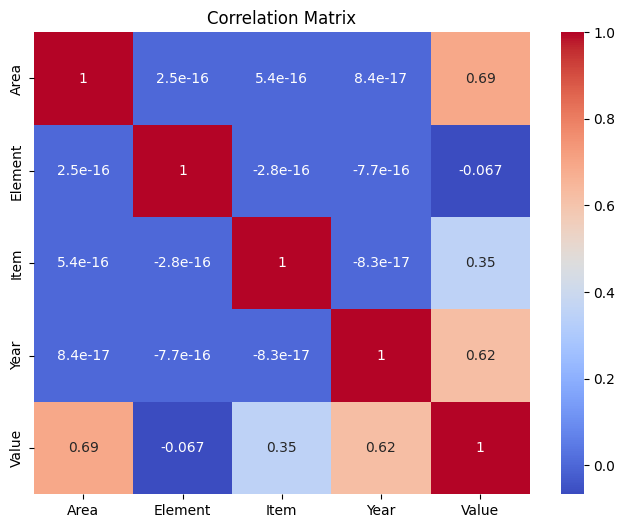

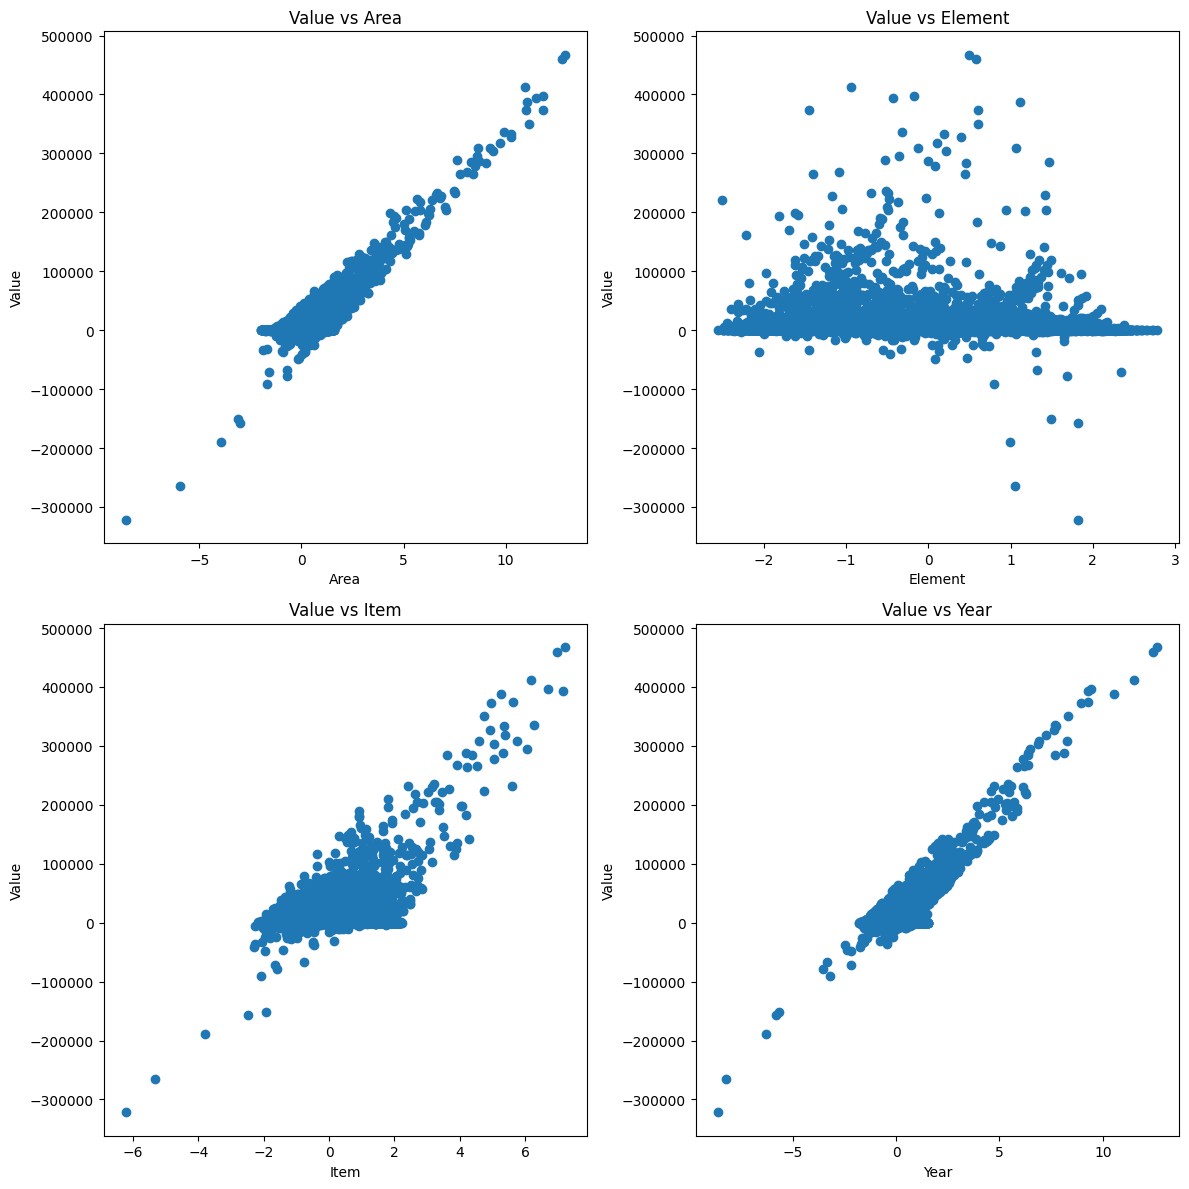

In [8]:
# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Create scatter plots
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Scatter plot of Value vs Area
axs[0, 0].scatter(new_data['Area'], new_data['Value'])
axs[0, 0].set_xlabel('Area')
axs[0, 0].set_ylabel('Value')
axs[0, 0].set_title('Value vs Area')

# Scatter plot of Value vs Element
axs[0, 1].scatter(new_data['Element'], new_data['Value'])
axs[0, 1].set_xlabel('Element')
axs[0, 1].set_ylabel('Value')
axs[0, 1].set_title('Value vs Element')

# Scatter plot of Value vs Item
axs[1, 0].scatter(new_data['Item'], new_data['Value'])
axs[1, 0].set_xlabel('Item')
axs[1, 0].set_ylabel('Value')
axs[1, 0].set_title('Value vs Item')

# Scatter plot of Value vs Year
axs[1, 1].scatter(new_data['Year'], new_data['Value'])
axs[1, 1].set_xlabel('Year')
axs[1, 1].set_ylabel('Value')
axs[1, 1].set_title('Value vs Year')

plt.tight_layout()
plt.show()

## Data Splitting

In [9]:
# Split the data into features (X) and target variable (y)
selected_features = ['Area', 'Item', 'Year', 'Value']
X = new_data[selected_features[:-1]] 
y = new_data['Value']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on training data and transform both training and testing data
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))

# Print the shapes of the training and testing sets
print("Training set shape (X_train):", X_train.shape)
print("Testing set shape (X_test):", X_test.shape)
print("Training set shape (y_train_scaled):", y_train_scaled.shape)
print("Testing set shape (y_test_scaled):", y_test_scaled.shape)


Training set shape (X_train): (9820, 3)
Testing set shape (X_test): (2456, 3)
Training set shape (y_train_scaled): (9820, 1)
Testing set shape (y_test_scaled): (2456, 1)


## Model Building 

In [10]:
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

In [11]:
history = model.fit(X_train, y_train, epochs=100, batch_size=50, validation_split=0.2, verbose=0)

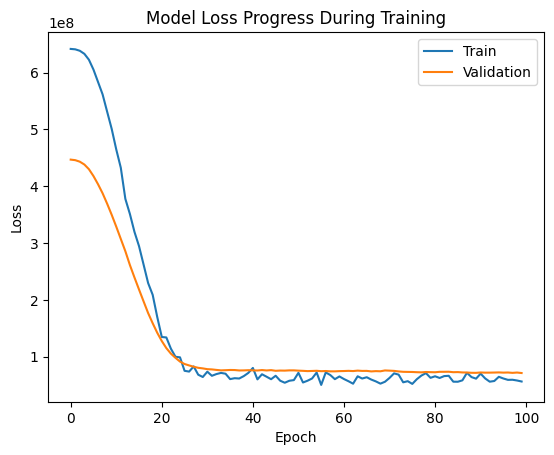

In [12]:
# Plotting training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progress During Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [13]:
# Make predictions on test data
predictions = model.predict(X_test)

# Print top five predictions
print(predictions[:5])

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step
[[-668.2349  ]
 [ 170.43437 ]
 [-700.3554  ]
 [ -40.552578]
 [ 102.79834 ]]


In [14]:
# Calculate RMSE by comparing predictions with actual values on the test set
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
print("Test RMSE: ", rmse)

Test RMSE:  2994.9993341447907


## Hyper Parameter Tuning

In [15]:
hyperparameters = {
    'epochs': [100, 200, 300],
    'dropout_rate': [0.2, 0.3, 0.5],
    'learning_rate': [0.001, 0.01, 0.1],
    'activation': ['relu', 'leaky_relu', 'elu']
}

In [16]:
def build_and_evaluate_model(X_train, y_train, X_test, y_test, params):
    # Select activation function based on parameter
    activation = params['activation']
    if activation == 'leaky_relu':
        activation_function = tf.keras.layers.LeakyReLU()
    elif activation == 'elu':
        activation_function = tf.keras.layers.ELU()
    else:
        activation_function = 'relu'

    # Build the model
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(64, activation=activation_function, kernel_regularizer=l2(0.01)),
        Dropout(params['dropout_rate']),
        Dense(32, activation=activation_function, kernel_regularizer=l2(0.01)),
        Dropout(params['dropout_rate']),
        Dense(1, activation='linear')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=params['learning_rate'])
    model.compile(optimizer=optimizer, loss='mse')

    # Train the model and evaluate
    try:
        history = model.fit(X_train, y_train_scaled, epochs=params['epochs'], batch_size=32, validation_split=0.2, verbose=0)
        predictions = model.predict(X_test)
        mse = mean_squared_error(y_test_scaled, predictions)
        rmse = np.sqrt(mse)
        return rmse, history
    except Exception as e:
        print("An error occurred:", e)
        return None, None


In [17]:
# Initialize a DataFrame to store results
results_df = pd.DataFrame()

# Experiment with each combination of hyperparameters
for values in itertools.product(*hyperparameters.values()):
    param_combination = dict(zip(hyperparameters.keys(), values))
    rmse, history = build_and_evaluate_model(X_train, y_train_scaled, X_test, y_test_scaled, param_combination)
    if rmse is not None:
        current_result = pd.DataFrame({
            'Epochs': [param_combination['epochs']],
            'Dropout Rate': [param_combination['dropout_rate']],
            'Learning Rate': [param_combination['learning_rate']],
            'Activation': [param_combination['activation']],
            'RMSE': [rmse]
        })
        # Concatenate the current results DataFrame with the main results DataFrame
        results_df = pd.concat([results_df, current_result], ignore_index=True)

print("Results collected.")

77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 409us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step
77/77 ━━━━━━━━━━

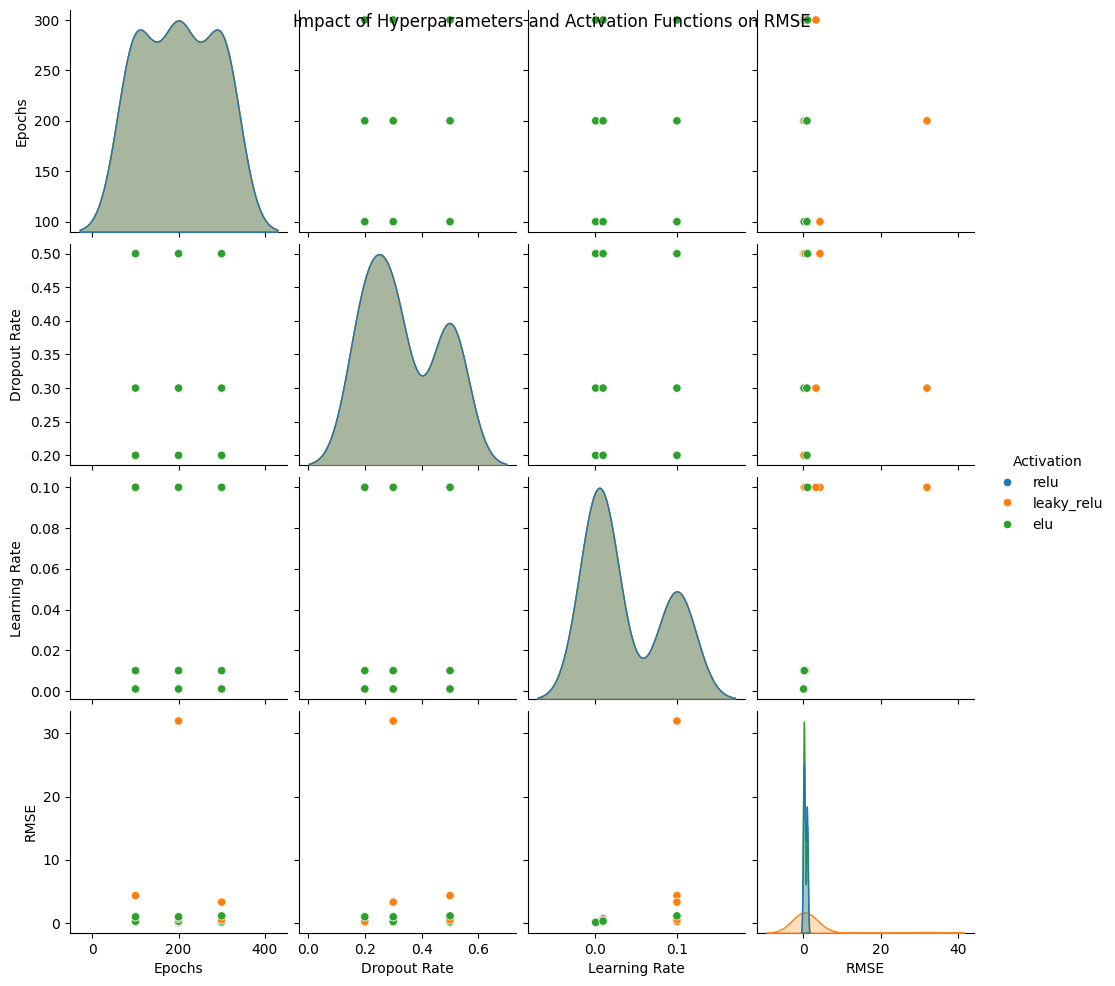

In [18]:
# Plot the results
sns.pairplot(results_df, hue='Activation', vars=['Epochs', 'Dropout Rate', 'Learning Rate', 'RMSE'])
plt.suptitle('Impact of Hyperparameters and Activation Functions on RMSE', verticalalignment='top')
plt.show()

In [19]:
sorted_results_df = results_df.sort_values('RMSE').head(10)
print(sorted_results_df)

    Epochs  Dropout Rate  Learning Rate  Activation      RMSE
36     200           0.3          0.001        relu  0.053181
28     200           0.2          0.001  leaky_relu  0.055525
37     200           0.3          0.001  leaky_relu  0.056182
10     100           0.3          0.001  leaky_relu  0.058190
73     300           0.5          0.001  leaky_relu  0.061753
63     300           0.3          0.001        relu  0.063189
64     300           0.3          0.001  leaky_relu  0.065250
40     200           0.3          0.010  leaky_relu  0.073331
45     200           0.5          0.001        relu  0.082837
18     100           0.5          0.001        relu  0.087944


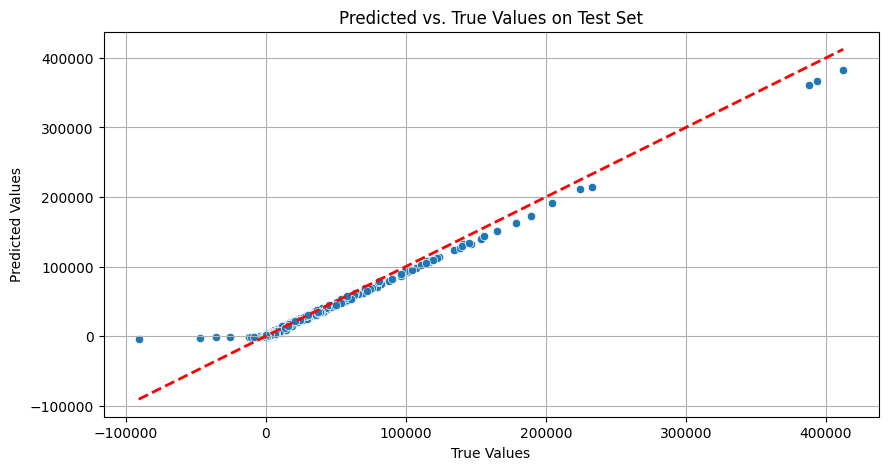

In [21]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_test, y=predictions.flatten())
plt.title('Predicted vs. True Values on Test Set')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red',lw=2, linestyle='--') # Diagonal line for reference
plt.grid(True)

## Predictions

In [20]:
data = pd.read_csv("Foreign direct investment - FAOSTAT_data_en_2-27-2024.csv")
X = data[["Area Code (M49)", "Item Code", "Year"]]
y = data[["Value"]]

scalers = {}
for feature in X.columns:
    scalers[feature] = StandardScaler()
    X[[feature]] = scalers[feature].fit_transform(X[[feature]])

model = Sequential([
    Input(shape=(X.shape[1],)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(1, activation='linear')
])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')
model.fit(X, y, epochs=200, verbose=0)

predictions_list = []
grouped_data = data.groupby(["Area Code (M49)", "Item Code"])
for (area_code, item_code), group_df in grouped_data:
    max_year = group_df['Year'].max()
    prediction_year = max_year + 3
    prediction_features = pd.DataFrame([[area_code, item_code, prediction_year]], columns=["Area Code (M49)", "Item Code", "Year"])
    prediction_features_scaled = pd.DataFrame({
        feature: np.array(scalers[feature].transform(prediction_features[[feature]].values.reshape(-1, 1))).flatten()
        for feature in prediction_features.columns
    })
    prediction = model.predict(prediction_features_scaled.values)
    predictions_list.append([area_code, item_code, prediction_year, prediction[0][0]])

predictions_df = pd.DataFrame(predictions_list, columns=["Area Code", "Item Code", "Year", "Value"])
predictions_df.index += 1
predictions_df.index.name = "ID"
predictions_df.to_csv("investment_predictions.csv")

print("Predictions generated and saved to investment_predictions.csv")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1